**분석개요**

    A. 가볼래터 성과 분석 리포트
        1. 매체별 유입 분석
            1) 유입
            2) 재방문
            3) 구독 전환
            4) 이상 유저
            5) 앱설치
            6) 활성
            7) 리텐션
        2. 이동 경로 분석

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
# import openpyxl
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import difflib

#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_config
import kto_util
import kto_prep
from kto_config import *
from kto_prep import *
from kto_util import *

for pkg in [kto_config, kto_prep, kto_util] :
    _ = importlib.reload(pkg)

# 1.Data Import

In [3]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# dates: 10월 한 달
df_app_log = DataImport.read_files(
    input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
    today = today + timedelta(days = 1), 
    dates = dates,
    platform_total = True, reduce_memory = True, verbose = False)
df_app_log_total = df_app_log.copy()

df_app_log_before = DataImport.set_date_range(df = df_app_log_total, start= datetime(2022,10,1), end = advertisement_date)
df_app_log_after = DataImport.set_date_range(df = df_app_log_total, start= advertisement_date, end = datetime(2022,11,3))
df_app_log_total = df_app_log.copy()

# 2.Preprocess

In [4]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) log
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log)                # log data
df_app_log_total = SpherePrep.BasicPrep.basic_prep(df_app_log_total)                # log data

## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER], drop_none_prop=False)       # user data

## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

# ## 3) param - 2
# _, df_param_all_session = DataImport.json_to_dataframe_nodeN( 
#     df_app_log, [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
#     ) ### + param by session

## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [42]:
# df_gudok_campaign_subscribe_done = df_gudok_campaign[df_gudok_campaign['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)]
# pd.set_option('max_rows', 100)
# df_gudok_campaign_subscribe_done.groupby(['referrer_utm_source', 'day']).size().to_frame()
# pd.set_option('max_rows', 30)

In [8]:
#------------------------------------------------#
# 2. param detail data
#------------------------------------------------#
## 1) event 기준
# df_param_install = DataImport.extract_event_param(df_param_all, EVENT_APP_INSTALL).drop_duplicates()
df_param_contents = DataImport.extract_event_param(df_param_all, EVENT_CONTENT_DETAIL).drop_duplicates()
df_param_subscribe = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE).drop_duplicates()
df_param_letter_main = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LETTER).drop_duplicates()
df_param_like = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LIKE).drop_duplicates()
df_param_signup = DataImport.extract_event_param(df_param_all, EVENT_SIGNUP).drop_duplicates()

## 2) 가볼래터 data 생성
df_param_contents_letter =\
     df_param_all[df_param_all[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)]

In [9]:
df_param_contents_letter[PARAM_CONTENT_NAME].unique()

array(['가볼래-터 구독하러 가기', "여행구독 '가볼래-터' 구독자 레벨업을 위한 ★미션 참여 방법& 선물 언박싱★",
       '매월 당신의 눈앞에 여행을 배송!가볼래-터 구독하러가기!',
       '매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!',
       '가볼래-터 9월호 OPEN! 인천 여행 특집 🚩',
       '핫플레이스와 신상 여행정보가 가득 담긴＇가볼래-터＇구독 신청하고 매월 초간단 미션을 완료하면 특별한 선물이 담긴 여행복권을 드립니다!',
       '＇가볼래-터＇구독 신청하고 미션 선물받자!',
       '[2차 앵콜] 다시 돌아온 가볼래-터 깜짝 이벤트! 여행구독 미션 참여하고, 카톡 이모티콘 받자!',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사 당첨자 발표',
       '매월 당신의 눈앞에 여행을 배송!매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!여행구독 <가볼래-터> 구독하러가기!',
       '여행구독 서비스! 가볼래-터 10월호 Open!', '여행을 구독하세요!가볼래-터 10월호 Open!',
       '여행을 구독하세요!✨가볼래-터 10월호 Open✨'], dtype=object)

## 1)Utils

In [10]:
# cnt -> percent function
def cnt_to_percent_ver1(df, col):
    df[col] = df[col].astype(float)

    if  df.index.dtype != 'str':
        df.index = df.index.astype('str')
    
    _lst = []
    for i in range(0,len(df)):
        x = round((df[col][i] / df[col].sum())*100, 2)
        _lst.append(x)

    df['percent']= _lst
    return df

# 기기당 이벤트 수 ver1
def cal_event_cnt_per_device_ver1(df_target, dict_referrs, lst_event, text):
    dict_page_cnt = {}
    for key, values in dict_referrs.items():
        _df = df_target[df_target[KEY_ID_DEVICE].isin(values)]
        _series_event_cnt = _df['abs_events'].apply(lambda x : len(set(x) & set(lst_event))
                                if len(set(lst_event) & set(x)) > 0 else 0)
        _df['page_cnt'] = _series_event_cnt
        EVENT_CNT_PER_DEVICE = _df.groupby([KEY_ID_DEVICE, 'day'])['page_cnt'].count().sum()
        
        dict_page_cnt[f'{key}'] = _series_event_cnt
        print(f'{key}', text, round(EVENT_CNT_PER_DEVICE, 2), '회')

## 기기당 이벤트 수 ver2
def cal_event_cnt_per_device_ver2(df_target, text):
        df_target['event_cnt'] = df_target['abs_events'].apply(lambda x: len(x))
        EVENT_CNT_PER_DEVICE = df_target.groupby([KEY_ID_DEVICE, 'day'])['event_cnt'].count().sum()
        print(text, round(EVENT_CNT_PER_DEVICE, 2), '회')

# divide top/mid/low
def divide_high_mid_low(df, col_nm):
    _dict_group = dict()
    _dict_group['high'] = df[
        df[col_nm] >= df[col_nm].quantile(0.66)].index
    _dict_group['middle'] = df[
        (df[col_nm] < df[col_nm].quantile(0.66)) &
        (df[col_nm] >= df[col_nm].quantile(0.33))].index
    _dict_group['low'] = df[
        df[col_nm] < df[col_nm].quantile(0.33)].index
    
    return _dict_group

def get_daily_cnt(
                  dict_output, lst, nm, dict_input, df_target = df_app_log_total, KEY_ID = KEY_ID_DEVICE, 
                  make_sub_dict = False):
    # 1. 전체 일별 수치
    df_daily = df_target[df_target[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'total_{nm}')

    # 2. 매체별 일별 수지
    for key, values in dict_input.items():
        _lst_id = list(set(lst) &  set(values))
        _df = df_target[df_target[KEY_ID].isin(_lst_id)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'{key}_{nm}').fillna(0)
        if make_sub_dict == True:
            dict_output[f'{key}'] = {}

        dict_output[f'{key}'][f'{nm}'] = _df
        # dict_output[f'{key}_{nm}'] 
        df_daily[f'{key}'] = _df[f'{key}_{nm}']
        df_daily.fillna(0, inplace=True)
        # pd.concat([df_daily, dict_output[f'{key}'][f'{key}_{nm}']], axis=1).fillna(0)
        
    return df_daily

# 3.Analysis
## 0)Segment Setting

In [11]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
dict_lst_user_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
dict_lst_user_from_referrs_gudok = dict_lst_user_from_referrs['2022_gudok']
dict_lst_user_from_referrs_gudok['organic']  = dict_lst_user_from_referrs['organic']['organic'] # organic 유입 추가

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_duration_seg = dict()
dict_duration_seg['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.66)].index
dict_duration_seg['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.66)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.33))
    ].index
dict_duration_seg['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.33)].index

#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_duration_per_device[df_duration_per_device < 5].index)
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
# ## gender
# dict_seg_gender = dict()
# dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
# dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

# ## age
# dict_seg_age = dict()
# # dict_seg_age['20_30'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) < 40][KEY_ID_DEVICE])
# # dict_seg_age['40_50'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) >= 40][KEY_ID_DEVICE])
# # # # ======================================================== #  next version
# dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
# dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe segment 
#------------------------------------------------#
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].values)

In [25]:
## prep referr 
#   FB_INSTA : instagram & FB_INSTA & Facebook
#   KAKAO_moment : kakao_mo & KAKAO_moment
#   kakaotalk_bizmessage --> 제외 (카카오 알림톡)
dict_lst_user_from_referrs_gudok['KAKAO_moment'] =\
    list(
        set(dict_lst_user_from_referrs_gudok['kakao_mo'] + dict_lst_user_from_referrs_gudok['KAKAO_moment'])
        )
dict_lst_user_from_referrs_gudok['FB_INSTA'] =\
    list(    
        set(dict_lst_user_from_referrs_gudok['instagram'] + dict_lst_user_from_referrs_gudok['FB_INSTA']+\
            dict_lst_user_from_referrs_gudok['Facebook'])
    )

del dict_lst_user_from_referrs_gudok['kakaotalk_bizmessage']
del dict_lst_user_from_referrs_gudok['kakao_mo']
del dict_lst_user_from_referrs_gudok['instagram']
del dict_lst_user_from_referrs_gudok['Facebook']

dict_lst_user_from_referrs_gudok.keys()

dict_keys(['GDN', 'KAKAO_moment', 'FB_INSTA', 'NAVER_GFA', 'organic'])

## 1)매체 성과 분석
### (1)유입
- 전체 유입
- 일별 유입
    - 전체 유입
    - 신규 유입
    - 기존 유입

In [27]:
#########################################
# 1. 매체별 전체 유입인원
#########################################
dict_output_inflow_cnt = {}

for key, values in dict_lst_user_from_referrs_gudok.items():
    dict_output_inflow_cnt[f'{key}'] = {}
    dict_output_inflow_cnt[f'{key}']['inflow_cnt'] = len(set(values))

df_total_inflow_referrs = pd.DataFrame.from_dict(dict_output_inflow_cnt, orient='index', columns=['inflow_cnt'])
df_total_inflow_referrs = cnt_to_percent_ver1(df_total_inflow_referrs, 'inflow_cnt')
df_total_inflow_referrs.sort_values(by = 'inflow_cnt', ascending=False)

# SphereVis.basic_bar_plot(
#     df_total_inflow_referrs, x = df_total_inflow_referrs.index, y = 'percent', title= '가볼래-터 매체별 전체 유입인원')
# plt.show()

,inflow_cnt,percent
organic,2158447.0,98.21
GDN,12402.0,0.56
NAVER_GFA,11473.0,0.52
FB_INSTA,8391.0,0.38
KAKAO_moment,7152.0,0.33


In [ ]:
dict_output_inflow_cnt

def get_daily_cnt(
                  dict_output, lst, nm, dict_input, df_target = df_app_log_total, KEY_ID = KEY_ID_DEVICE, 
                  make_sub_dict = False):
    # 1. 전체 일별 수치
    df_daily = df_target[df_target[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'total_{nm}')

    # 2. 매체별 일별 수지
    for key, values in dict_input.items():
        _lst_id = list(set(lst) &  set(values))
        _df = df_target[df_target[KEY_ID].isin(_lst_id)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'{key}_{nm}').fillna(0)
        if make_sub_dict == True:
            dict_output[f'{key}'] = {}

        dict_output[f'{key}'][f'{nm}'] = _df
        # dict_output[f'{key}_{nm}'] 
        df_daily[f'{key}'] = _df[f'{key}_{nm}']
        df_daily.fillna(0, inplace=True)
        # pd.concat([df_daily, dict_output[f'{key}'][f'{key}_{nm}']], axis=1).fillna(0)
        
    return df_daily

In [29]:
#########################################
# 2. 일별 유입
#########################################
## 1) 전체 유입
df_daily_total_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=list(df_app_log_total[KEY_ID_DEVICE].unique()), nm='inflow', 
                    dict_input = dict_lst_user_from_referrs_gudok)
pd.set_option('max_rows', 100)
df_daily_total_inflow
pd.set_option('max_rows', 30)

,total_inflow,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,
2022-10-01,118057,4,1,2.0,12,117597
2022-10-02,104588,4,1,2.0,14,104197
2022-10-03,75489,6,1,2.0,9,75090
2022-10-04,71652,5,2,4.0,13,71204
2022-10-05,69234,2,1,7.0,5,68616
2022-10-06,59372,2,3,0.0,13,58908
2022-10-07,85988,6,6,3.0,19,85288
2022-10-08,136494,6,5,3.0,24,135947
2022-10-09,76787,8,1,4.0,16,76338


In [30]:
# #########################################
# # 2. 일별 유입
# #########################################
# ## 2) 신규 유입
# df_daily_new_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_new_device, nm='new_inflow', 
#                     dict_input = dict_lst_user_from_referrs_gudok)
# df_daily_new_inflow

# ## 3) 기존 유입
# df_daily_re_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_re_device, nm='re_inflow',
#                     dict_input=dict_lst_user_from_referrs_gudok)
# df_daily_re_inflow

### (2)재방문
- 방문 빈도별 재방문율
- 주차별 재방문율

,index,only_1_visit_rate,re_visit_rate,re_visit_over_3_rate
0,GDN,0.8593,0.1407,0.0481
1,FB_INSTA,0.8803,0.1197,0.0232
2,organic,0.8849,0.1151,0.0417
3,NAVER_GFA,0.8906,0.1094,0.0378
4,KAKAO_moment,0.9372,0.0628,0.0159


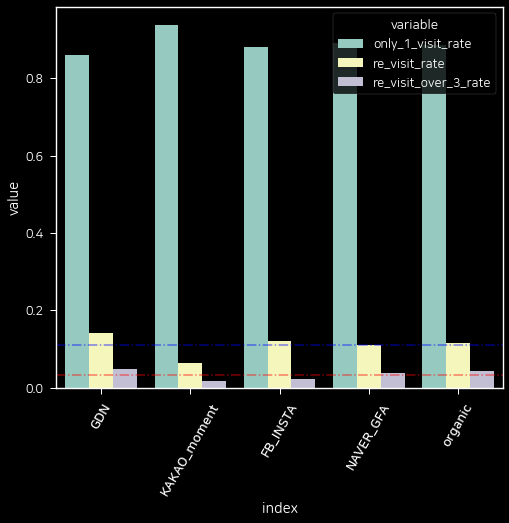

In [50]:
#------------------------------------------------#
## 2. 재방문율
#------------------------------------------------#
### 1) 1회 / 2회 이상 / 3회 이상 방문자
#### prep
dict_output_1_2 = dict()
for _referrer in list(dict_lst_user_from_referrs_gudok.keys()) :
    dict_output_1_2[_referrer] = dict()
    _segment = dict_lst_user_from_referrs_gudok[_referrer]
    _df_user_day_cnt = df_app_log[df_app_log[KEY_ID_DEVICE].isin(_segment)].groupby(KEY_ID_DEVICE)['day'].count()

    only_1_visit_rate = round(_df_user_day_cnt.value_counts()[1] / len(_segment), 4)
    re_visit_rate = round(1 - only_1_visit_rate, 4)
    re_visit_over_3_rate = round(1 - _df_user_day_cnt.value_counts()[:2].sum() / len(_segment), 4)
    
    dict_output_1_2[_referrer]['only_1_visit_rate'] = only_1_visit_rate
    dict_output_1_2[_referrer]['re_visit_rate'] = re_visit_rate
    dict_output_1_2[_referrer]['re_visit_over_3_rate'] = re_visit_over_3_rate

pd.DataFrame.from_dict(
    dict_output_1_2, orient = 'index'
    ).sort_values(by = 're_visit_rate', ascending=False).reset_index()
df_vis_1_2_retention = pd.DataFrame.from_dict(
    dict_output_1_2, orient = 'index'
    ).reset_index().melt(id_vars='index')
avg_rate_re_visit_over_2 = df_vis_1_2_retention[
    df_vis_1_2_retention['variable'] == 're_visit_rate'].mean().value
avg_rate_re_visit_over_3 = df_vis_1_2_retention[
    df_vis_1_2_retention['variable'] == 're_visit_over_3_rate'].mean().value

#### vis
ax = sns.barplot(
    data = df_vis_1_2_retention.reset_index(),
    x = 'index', y = 'value',
    capsize = 2 , alpha = 1, hue = 'variable'
    )
_ = plt.xticks(rotation=60, fontproperties = fprop)
_ = plt.axhline(y=avg_rate_re_visit_over_2, color='blue', ls = '-.', alpha = 0.5, label = 'a')
_ = plt.axhline(y=avg_rate_re_visit_over_3, color='red', ls = '-.', alpha = 0.5, label = 'a')
plt.show()

In [51]:
#########################################
# 1. 방문 빈도별 재방문율
#########################################
## data setting by referrs
dict_visit_cnt = {}
dict_df_param_contents = {}

# key, values로 하지말고, 해당 변수를 추측가능하게끔 네이밍
for key, values in dict_lst_user_from_referrs_gudok.items():
    # 재방문 지표를 계산하는데, 시작을 굳이 '가볼레터' 페이지로 한정지을 필요 없음
    dict_df_param_contents[key] = df_param_contents_letter[
                                        df_param_contents_letter[KEY_ID_DEVICE].isin(
                                            dict_lst_user_from_referrs_gudok[key])]
                                            
    # 재방문 지표를 계산하는데, 컨텐츠 조회 외에도 이벤트는 존재함. 따라서 이역시도 재방문을 측정하는데, 누락이 생기는 방식임.
    _df = dict_df_param_contents[key].groupby(KEY_ID_DEVICE)['day'].size().to_frame(
        name = 'day_cnt')


    VISIT_1_CNT = len(_df[_df['day_cnt'] == 1])
    VISIT_2_CNT = len(_df[_df['day_cnt'] == 2])     # 재방문은 2회 이상 재접속하면, 재방문을 의미함. 현재 코드는 단 2회만 방문한 유저를 재방문이라고 정의하고 엑셀에도 적어뒀음. 3회를  포함해야함
    VISIT_3_CNT = len(_df[_df['day_cnt'] >= 3])

    VISIT_1_RATE = VISIT_1_CNT / len(_df)
    REVISIT_2_RATE= 1 - VISIT_1_RATE
    REVISIT_3_RATE = 1 - ((VISIT_1_CNT + VISIT_2_CNT) / len(_df))

    # dict_visit_cnt[f'{key}'] = {}
    dict_visit_cnt[f'{key}']= [VISIT_1_RATE, REVISIT_2_RATE, REVISIT_3_RATE]

df_vis_revisit = pd.DataFrame.from_dict(
    dict_visit_cnt, orient='index', columns=[
        'only_1_visit', 'revisit_rate', 'revisit_over_3_rate'])

df_vis_revisit

,only_1_visit,revisit_rate,revisit_over_3_rate
GDN,0.777877,0.222123,0.099297
KAKAO_moment,0.915162,0.084838,0.023940
FB_INSTA,0.818409,0.181591,0.067605
NAVER_GFA,0.864365,0.135635,0.053957
organic,0.650115,0.349885,0.197189


In [32]:
# #########################################
# # 2. 주차별 재방문율
# #########################################
# ## 1) 전체 주차별 재방문율
# df_retention = SphereRetention.retention_main(
#     df_app_log, KEY_ID = KEY_ID_DEVICE, period = 'week', vis = True, title = 'Total Retention')

# ## 2) 매체별 주차별 재방문율
# for key, values in dict_lst_user_from_referrs_gudok.items():
#     df_retention = SphereRetention.retention_main(
#         df_app_log[df_app_log[KEY_ID_DEVICE].isin(values)], 
#         KEY_ID = KEY_ID_DEVICE, period = 'week', vis = True, title = f'{key} Retention')

### (3)구독전환
- 구독전환수
- 구독전환율

In [34]:
#########################################
# 1. 구독완료
#########################################
## 1) 일별 구독완료 유저 수
dict_subscribe = {}
df_daily_subscribe = pd.DataFrame()

_df_log_target = df_app_log_total[
    df_app_log_total['abs_events'].apply(
        lambda x : True if EVENT_SUBSCRIBE in x else False
        )]

df_daily_subscribe = _df_log_target.groupby('day')[KEY_ID_DEVICE]\
                    .nunique().to_frame(name = 'total_subscribe_cnt')

_lst_device = list(_df_log_target[KEY_ID_DEVICE].unique())

# 2. 매체별 일별 수지
for key, values in dict_lst_user_from_referrs_gudok.items():
    _lst_id = list(set(_lst_device) &  set(values))
    _df = _df_log_target[_df_log_target[KEY_ID_DEVICE].isin(_lst_id)].groupby('day')[KEY_ID_DEVICE]\
                .nunique().to_frame(name = f'{key}_subscribe_cnt').fillna(0)

    dict_subscribe[f'{key}'] = {}
    dict_subscribe[f'{key}']['subscribe_cnt'] = _df
    # dict_output[f'{key}_{nm}'] 
    df_daily_subscribe[f'{key}'] = _df[f'{key}_subscribe_cnt']
    df_daily_subscribe.fillna(0, inplace=True)

pd.set_option('max_rows', 100)
df_daily_subscribe
pd.set_option('max_rows', 30)

,total_subscribe_cnt,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,
2022-10-01,75,0.0,0.0,0.0,0.0,75
2022-10-02,66,0.0,0.0,0.0,0.0,66
2022-10-03,57,0.0,0.0,0.0,0.0,57
2022-10-04,67,0.0,0.0,0.0,0.0,66
2022-10-05,68,0.0,0.0,0.0,0.0,63
2022-10-06,72,0.0,0.0,0.0,0.0,71
2022-10-07,99,0.0,0.0,0.0,0.0,99
2022-10-08,45,0.0,0.0,0.0,0.0,45
2022-10-09,61,0.0,0.0,0.0,0.0,61


In [53]:
#########################################
# 2. 구독전환율
#########################################
## 매체별 전환율
### 랜딩페이지 > 구독
df_subscribe_conversion = pd.DataFrame(
                            index=[
                                'landing_cnt', 
                                'subscribe_cnt', 
                                'subscribe_conversion'])

for key, _lst_referr in dict_lst_user_from_referrs_gudok.items():
    # _df = df[df[PARAM_CONTENT_NAME] == '가볼래-터 구독하러 가기']
    LANDING_CNT = len(_lst_referr)# _df[KEY_ID_DEVICE].nunique()

    _df = df_param_subscribe[
                        df_param_subscribe[KEY_ID_DEVICE].isin(
                            _lst_referr
                            #list(_df[KEY_ID_DEVICE])
                        )]
    SUBSCRIBE_CNT = _df[KEY_ID_DEVICE].nunique()
    dict_subscribe[f'{key}']['subscribe_conversion'] = [LANDING_CNT,
                                                    SUBSCRIBE_CNT, 
                                                    (SUBSCRIBE_CNT/LANDING_CNT)]

    df_subscribe_conversion[f'{key}'] =\
        dict_subscribe[f'{key}']['subscribe_conversion']

df_subscribe_conversion

,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
landing_cnt,12402.000000,7152.00000,8391.000000,11473.000000,2.158447e+06
subscribe_cnt,6.000000,2.00000,119.000000,46.000000,1.938000e+03
subscribe_conversion,0.000484,0.00028,0.014182,0.004009,8.978678e-04


### (4)Fraud
- 바운스율
- 정착율

In [41]:
#########################################
# 1. 바운스 유저 비율 & 정착 유저 비율 -- 기존 코드
#########################################
dict_fraud_referrs = {}
lst_fraud_device = []
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = df_app_log[df_app_log[KEY_ID_DEVICE].isin(values)]
    _df_sum = _df.groupby(KEY_ID_DEVICE)['duration'].sum().reset_index()
    _df_cnt = _df.groupby(KEY_ID_DEVICE).size().to_frame().rename(columns={0:'cnt'})
    _df_per_duration = pd.merge(_df_sum, _df_cnt, how='inner', on=KEY_ID_DEVICE)
    _df_per_duration['per_duration'] = _df_per_duration['duration'] / _df_per_duration['cnt']
    
    _lst_device_fraud = list(_df_per_duration[KEY_ID_DEVICE][_df_per_duration['per_duration'] < 5].unique())
    lst_fraud_device += _lst_device_fraud

    TOTAL_CNT = _df[KEY_ID_DEVICE].nunique()
    FRAUD_CNT = len(_lst_device_fraud)
    FRAUD_RATE = FRAUD_CNT / TOTAL_CNT
    SETTLE_RATE = 1 - FRAUD_RATE                                

    dict_fraud_referrs[f'{key}'] = [TOTAL_CNT, FRAUD_CNT, FRAUD_RATE, SETTLE_RATE]
lst_fraud_device = list(set(lst_fraud_device))

df_fraud_referrs = pd.DataFrame.from_dict(
    dict_fraud_referrs, orient='index', columns=[
        'total_cnt', 'fraud_cnt', 'fraud_rate', 'settle_rate'])

df_fraud_referrs

,total_cnt,fraud_cnt,fraud_rate,settle_rate
GDN,12394,10229,0.825319,0.174681
KAKAO_moment,12629,7484,0.592604,0.407396
FB_INSTA,8391,7167,0.854129,0.145871
NAVER_GFA,11473,10351,0.902205,0.097795
organic,2117384,1591374,0.751576,0.248424


In [81]:
#########################################
# 1. 바운스 유저 비율 & 정착 유저 비율 -- 수정 코드
#########################################
dict_fraud_referrs = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _lst_device_fraud = list(set(values) & set(lst_fraud_device))
    
    TOTAL_CNT = len(values)
    FRAUD_CNT = len(_lst_device_fraud)
    FRAUD_RATE = FRAUD_CNT / TOTAL_CNT
    SETTLE_RATE = 1 - FRAUD_RATE                                

    dict_fraud_referrs[f'{key}'] = [TOTAL_CNT, FRAUD_CNT, FRAUD_RATE, SETTLE_RATE]

df_fraud_referrs = pd.DataFrame.from_dict(
    dict_fraud_referrs, orient='index', columns=[
        'total_cnt', 'fraud_cnt', 'fraud_rate', 'settle_rate'])

df_fraud_referrs

,total_cnt,fraud_cnt,fraud_rate,settle_rate
GDN,12402,9943,0.801726,0.198274
KAKAO_moment,7152,6667,0.932187,0.067813
FB_INSTA,8391,7121,0.848647,0.151353
NAVER_GFA,11473,10178,0.887126,0.112874
organic,2158447,1576003,0.730156,0.269844


### (5)앱설치 유저

In [75]:
# #########################################
# # 0. prep
# #########################################
df_id_prep = SpherePrep.Prop.df_prop_pipe(
                df_app_log, [KEY_ID_DEVICE, KEY_ID_USER], 
                drop_none_prop = False)

EVENT_APP_INSTALL = '#appInstall'
app_key_android = 'qsJfZhE2Ft85SvZoXInoo3'
app_key_ios = 'qsJfZhE2Ft85SvZTOvxsUA'
#########################################
# 1. 앱설치 유저
#########################################
dict_install = {}
df_install_cnt = pd.DataFrame()
_df_log_install = df_app_log[df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False)]

for key, _lst_referr in dict_lst_user_from_referrs_gudok.items():
    ## 1) 캠페인 유저의 사용자 ID 추출
    _lst_campaign_user_id = list(set(df_id_prep[df_id_prep[KEY_ID_DEVICE].isin(_lst_referr)][KEY_ID_USER]))
    
    ## 2) 캠페인 유저의 사용자 ID중 android & ios 앱 사용자
    dict_install[f'{key}'] = {}
    _lst_campaign_user_ids =\
        list(
            df_app_log[
            (df_app_log['app_key'].isin([app_key_android, app_key_ios])) & 
            (df_app_log[KEY_ID_USER].isin(_lst_campaign_user_id))
            ][KEY_ID_USER].unique()
            )
        # _df_log_install[_df_log_install[KEY_ID_USER].isin(_lst_user_id)][KEY_ID_USER]

    dict_install[f'{key}'] = len(_lst_campaign_user_ids)
    # df_install_cnt[f'{key}_cnt'] = dict_install[f'{key}']['cnt']

    # print(f'{key}: ', dict_install[f'{key}']['cnt'])

df_install_referrs = pd.DataFrame.from_dict(
dict_install, orient='index', columns= ['install_cnt'])
df_install_referrs

,install_cnt
GDN,6
KAKAO_moment,2
FB_INSTA,57
NAVER_GFA,20
organic,7777


In [16]:
# # 2. gender & age_group 
# ## KAKAO_moment: drop (설치자 0명이라서)
# dict_lst_user_from_referrs_gudok_demo = dict_lst_user_from_referrs_gudok
# del dict_lst_user_from_referrs_gudok_demo['KAKAO_moment']
3
# ## 시각화
# Profiling.demo_profiling( 
#     df_user_prop=df_prop, KEY_ID=KEY_ID_DEVICE, 
#     dict_user_list=dict_lst_user_from_referrs_gudok_demo, 
#     total_avg = True, vis_type = 'all')

In [45]:
# ## exact numbers age/gender by referrs
# _df_gender = pd.DataFrame()
# _df_age = pd.DataFrame()

# for key, lst_id in dict_lst_user_from_referrs_gudok_demo.items():
#     if key != 'total':
#         _df = df_prop[df_prop[KEY_ID_DEVICE].isin(lst_id)]
#         _df_gender = pd.concat(
#             [_df_gender, _df['gender'].value_counts().to_frame(name = f'{key}_gender')], axis=1).fillna(0)
#         _df_age = pd.concat(
#             [_df_age, _df['age_group'].value_counts().to_frame(name = f'{key}_age')], axis=1).fillna(0)
#     else:
#         pass

# _df_gender
# _df_age

### (6)활성
- 인당 체류 시간
- 인당 컨텐츠 조회수
- 검색 조회 빈도

In [83]:
#########################################
# 1. 인당 체류시간
#########################################
lst_device_no_fraud = list(set(lst_total_device) - set(lst_fraud_device))
_df_log_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

dict_duration = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target[_df_log_target[KEY_ID_DEVICE].isin(values)]

    dict_duration[f'{key}'] = {}
    dict_duration[f'{key}']['duration'] = _df.groupby(
                        KEY_ID_DEVICE)['duration'].sum().to_frame(
                            name = 'total_duration')
                            
    # dict_duration[f'{key}']['duration'] 
    print(f'{key} 인당 평균 체류시간: ', round(dict_duration[f'{key}']['duration']['total_duration'].mean(), 2), '초')

GDN 인당 평균 체류시간:  392.05 초
KAKAO_moment 인당 평균 체류시간:  327.88 초
FB_INSTA 인당 평균 체류시간:  128.21 초
NAVER_GFA 인당 평균 체류시간:  292.53 초
organic 인당 평균 체류시간:  283.77 초


In [84]:
# #########################################
# # 2. 인당 컨텐츠 조회수 -- 기존
# #########################################
# lst_landing_device = df_param_contents[KEY_ID_DEVICE][
#     df_param_contents[PARAM_CONTENT_NAME]=='가볼래-터 구독하러 가기']
# lst_event_letter =\
#         ['balanceGameMain', 'balanceGame', 'travelLetterDetail', 'travelLetterLike', 'travelLetterNotLike']
# lst_event_total = [EVENT_CONTENT_DETAIL, EVENT_SEARCH]

# ## 1) 매체별 가볼래-터 관련 컨텐츠 한정 인당 일별 조회 수
# ### (1) 이상 유저 제거 x
# #### prep
# _df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

# _df_log_target = _df_log_target_letter[
#     _df_log_target_letter['abs_events'].apply(lambda x : True
#                                     if len(set(lst_event_letter) & set(x)) > 0 else False)]

# #### calculate event cnt
# print('인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 포함)')
# cal_event_cnt_per_device_ver1(
#         _df_log_target, dict_lst_user_from_referrs_gudok, 
#         lst_event_letter, '가볼래-터 관련 일별 총 컨텐츠 조회수: ')

# print('-'*50)
# print('인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 제거)')

# ### (2) 이상 유저 제거 o --> 거의 차이 없어 주석 처리함!!
# #### prep
# _df_log_target_no_fraud =\
#         _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

# _df_log_target_no_fraud_prep = _df_log_target_no_fraud[
#     _df_log_target_no_fraud['abs_events'].apply(lambda x : True
#                                     if len(set(lst_event_letter) & set(x)) > 0 else False)]

# #### calculate event cnt
# cal_event_cnt_per_device_ver1(
#         _df_log_target_no_fraud_prep, dict_lst_user_from_referrs_gudok, 
#         lst_event_letter,'가볼래-터 관련 일별 총 컨텐츠 조회수: ')

In [87]:
#########################################
# 2. 인당 컨텐츠 조회수 -- 수정
#########################################
dict_events_cnt_output = {}
## 1) 매체별 가볼래-터 관련 컨텐츠 한정 인당 일별 조회 수
for _key, _lst_referr in dict_lst_user_from_referrs_gudok.items() :

    _df_app_log_by_referr = df_app_log[
        df_app_log[KEY_ID_DEVICE].isin(_lst_referr)
        ]
    _df_app_log_by_referr['events_cnt'] = _df_app_log_by_referr['abs_events'].apply(lambda x : len(x))

    dict_events_cnt_output[_key] = _df_app_log_by_referr.groupby(KEY_ID_DEVICE)['events_cnt'].sum().mean()
pd.DataFrame.from_dict(dict_events_cnt_output, orient='orient' )

,0
GDN,1.626834
KAKAO_moment,1.244407
FB_INSTA,1.992015
NAVER_GFA,2.018217
organic,3.533841


In [50]:
#########################################
# 2. 인당 컨텐츠 조회수
#########################################
## 2) 매체별 전체 컨텐츠 한정 인당 일별 조회 수
### (1) 이상 유저 제거 x
_df_log_target_total = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]
_df_log_target2 = _df_log_target_total[
    _df_log_target_total['abs_events'].apply(lambda x : True
                                    if len(set([EVENT_CONTENT_DETAIL]) & set(x)) > 0 else False)]
                                    
#### calculate event cnt
print('인당 전체 컨텐츠 조회수(이상 유저 포함)')
cal_event_cnt_per_device_ver1(
        _df_log_target2, dict_lst_user_from_referrs_gudok, 
        lst_event = [EVENT_CONTENT_DETAIL], text='일별 총 컨텐츠 조회수: ')

print('-'*50)

### (2) 이상 유저 제거 o --> 거의 차이 없어 주석 처리함!!
#### prep
_df_log_target_no_fraud2 =\
        _df_log_target_total[_df_log_target_total[KEY_ID_DEVICE].isin(lst_device_no_fraud)]
_df_log_target_no_fraud_prep = _df_log_target_no_fraud2[
    _df_log_target_no_fraud2['abs_events'].apply(lambda x : True
                                    if len(set([EVENT_CONTENT_DETAIL]) & set(x)) > 0 else False)]

#### calculate event cnt
print('인당 전체 컨텐츠 조회수(이상 유저 제거)')
cal_event_cnt_per_device_ver1(
        _df_log_target_no_fraud_prep, dict_lst_user_from_referrs_gudok, 
        lst_event = [EVENT_CONTENT_DETAIL], text='일별 총 컨텐츠 조회수: ')


인당 전체 컨텐츠 조회수(이상 유저 포함)
GDN 일별 총 컨텐츠 조회수:  15268 회
KAKAO_moment 일별 총 컨텐츠 조회수:  11313 회
FB_INSTA 일별 총 컨텐츠 조회수:  9637 회
NAVER_GFA 일별 총 컨텐츠 조회수:  13741 회
organic 일별 총 컨텐츠 조회수:  102268 회
--------------------------------------------------
인당 전체 컨텐츠 조회수(이상 유저 제거)
GDN 일별 총 컨텐츠 조회수:  3388 회
KAKAO_moment 일별 총 컨텐츠 조회수:  4067 회
FB_INSTA 일별 총 컨텐츠 조회수:  1809 회
NAVER_GFA 일별 총 컨텐츠 조회수:  2127 회
organic 일별 총 컨텐츠 조회수:  99650 회


In [88]:
# #########################################
# # 2. 인당 컨텐츠 조회수
# #########################################
# ## 3) 전체 컨텐츠 인당 일별 조회 수
# ### (1) 랜딩 페이지 접속 유저
# #### 이상 유저 제거 x
# print('인당 전체 컨텐츠 조회수')
# cal_event_cnt_per_device_ver2(_df_log_target_letter,
#         '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')

# #### 이상 유저 제거 o
# cal_event_cnt_per_device_ver2(_df_log_target_no_fraud,
#         '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')


# ### (2) 랜딩 페이지 접속 x 유저
# #### 이상 유저 제거 x
# lst_not_landing_device = set(lst_total_device) - set(lst_landing_device)
# _df_log_target3 = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_not_landing_device)]
# cal_event_cnt_per_device_ver2(_df_log_target3,
#         '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')


# #### 이상 유저 제거 o
# _df_log_target_no_fraud3 =\
#         _df_log_target3[_df_log_target3[KEY_ID_DEVICE].isin(lst_device_no_fraud)]
# cal_event_cnt_per_device_ver2(_df_log_target_no_fraud3,
#         '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')

In [89]:
# #########################################
# # 3. 인당 검색 조회 빈도
# #########################################
# ## 1) 랜딩페이지 접속 유저
# ### 이상 유저 포함
# _df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

# dict_search = {}
# for key, values in dict_lst_user_from_referrs_gudok.items():
#     _df = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(values)]
#     _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
#     dict_search[f'{key}_이상 유저 포함'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
#     print(f'{key} 인당 검색 조회 빈도(이상 유저 포함): ', round(dict_search[f'{key}_이상 유저 포함'], 2), '회')

# print('-'*50)

# ### 이상 유저 제거 --> 차이 없음!
# _df_log_target_no_fraud =\
#      _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

# for key, values in dict_lst_user_from_referrs_gudok.items():
#     _df = _df_log_target_no_fraud[_df_log_target_no_fraud[KEY_ID_DEVICE].isin(values)]
#     _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
#     dict_search[f'{key}_이상 유저 제거'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
#     print(f'{key} 인당 검색 조회 빈도(이상 유저 제거): ', round(dict_search[f'{key}_이상 유저 제거'] , 2), '회')

## 2)이동경로
- 광고 유입
    - 구독 완료자 이동 경로
    - 구독 미완료자 이동 경로

- 자연 유입
    - 구독 완료자 이동 경로
    - 구독 미완료자 이동 경로
    - 도착 지점 도착 유저 이동 경로
    - 도착 지점 미도착 유저 이동 경로

In [104]:
from collections import Counter
## 1) 가볼래터 캠페인 참가자의 데이터 생성
### (1) 참가 device
lst_campaign_device = list(df_app_log[df_app_log['referrer_utm_campaign'] == '2022_gudok'][KEY_ID_DEVICE].unique())
lst_campaign_subscribe_o = list(set(lst_campaign_device) & set(lst_subscribe_device))
lst_campaign_subscribe_x = list(set(lst_campaign_device) - set(lst_campaign_subscribe_o))

### 구독 미완료 

In [110]:
# make sequance data
dict_journey_subset_to_kpi = {}
dict_journey_subset_after_kpi = {}

## 구독 완료 유저
for _key_id in df_param_campagin_session_letter[KEY_ID_DEVICE].unique() : 
    _df_journey_subset = df_param_campagin_session_letter[df_param_campagin_session_letter[KEY_ID_DEVICE] == _key_id].reset_index(drop = True)
    if '구독신청 완료!' in _df_journey_subset[PARAM_CONTENT_NAME].unique() :
        kpi_index = _df_journey_subset[_df_journey_subset[PARAM_CONTENT_NAME] == '구독신청 완료!'].index[0]
        _df_journey_subset_to_kpi = _df_journey_subset.iloc[:kpi_index+1]
        _df_journey_subset_after_kpi = _df_journey_subset.iloc[kpi_index+1:]
        try : _dict_journey_subset_to_kpi = _df_journey_subset_to_kpi[['name']].T.to_dict(orient = 'records')[0]
        except : pass
        try : _dict_journey_subset_after_kpi = _df_journey_subset_after_kpi[['name']].T.to_dict(orient = 'records')[0]
        except : pass
        
        for i, _event in _dict_journey_subset_to_kpi.items() :
            if i not in dict_journey_subset_to_kpi.keys() :
                dict_journey_subset_to_kpi[i] = [_event]
            else :
                dict_journey_subset_to_kpi[i] = dict_journey_subset_to_kpi[i] + [_event]


In [121]:
# output
for i in range(5) : 
    df_seq = pd.DataFrame.from_dict(Counter(dict_journey_subset_to_kpi[i]), orient='index', columns=['cnt'])
    df_seq['percent'] = round(df_seq['cnt'] / df_seq['cnt'].sum() * 100, 2)
    df_seq = df_seq.rename(columns={'cnt' : f'{i+1} step'})
    df_seq.head(3)

,1 step,percent
가볼래-터 구독하러 가기,170,75.22
balanceGameMain,33,14.60
sapContentDetail,10,4.42


,2 step,percent
지금 바로 구독하기,91,40.27
가볼래-터 구독하러 가기,39,17.26
balanceGame,24,10.62


,3 step,percent
sapLogin,79,34.96
가볼래-터 구독하러 가기,74,32.74
travelLetterLike,1,0.44


,4 step,percent
가볼래-터 구독하러 가기,89,39.56
sapLogin,48,21.33
sapContentDetail,2,0.89


,5 step,percent
지금 바로 구독하기,58,26.98
구독신청 완료!,23,10.70
가볼래-터 구독하러 가기,42,19.53


### 구독 미완료 

In [123]:
# for _lst_target in [lst_campaign_subscribe_x, lst_campaign_subscribe_o] :
lst_target = lst_campaign_subscribe_o
### (2) session data frame
_, df_param_campagin_session = DataImport.json_to_dataframe_nodeN( 
    df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_target)], 
    [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
    ) ### + param by session
df_param_campagin_session['date'] = pd.to_datetime(df_param_campagin_session['date'], format='%Y%m%d %H:%M:%S')
df_param_campagin_session['date_hm'] = df_param_campagin_session['date'].apply(lambda x : x.strftime('%y-%m-%d %H:%M'))

### 2) 가볼래터 이벤트명 변경 data 생성
df_param_contents_letter =\
     df_param_campagin_session[
        (df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)) | 
        (df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('구독', na=False))
        ]
### 구독 이벤트명 변경
df_param_contents_letter['name'] =  df_param_contents_letter[PARAM_CONTENT_NAME]

df_param_contents_except_letter =\
     df_param_campagin_session[
        ~(df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False) ) &
        ~(df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('구독', na=False) )
        ]

df_param_campagin_session_letter = pd.concat([
    df_param_contents_letter,
    df_param_contents_except_letter
])

df_param_campagin_session_letter = df_param_campagin_session_letter.sort_values(by = ['sid', 'date'])
df_param_campagin_session_letter = df_param_campagin_session_letter.drop_duplicates(['sid', 'date_hm', 'name'], keep='first') # 동일 분 안에 중복 이벤트 제거

In [147]:
# make sequance data
dict_journey_subset_to_kpi = {}
dict_journey_subset_after_kpi = {}
dict_journey_subset_churn = {}

for _key_id in df_param_campagin_session_letter[KEY_ID_DEVICE].unique()[:3000] : 
    _df_journey_subset = df_param_campagin_session_letter[df_param_campagin_session_letter[KEY_ID_DEVICE] == _key_id].reset_index(drop = True)
    ## 구독 완료 유저
    if '구독신청 완료!' in _df_journey_subset[PARAM_CONTENT_NAME].unique() :
        kpi_index = _df_journey_subset[_df_journey_subset[PARAM_CONTENT_NAME] == '구독신청 완료!'].index[0]
        _df_journey_subset_to_kpi = _df_journey_subset.iloc[:kpi_index+1]
        _df_journey_subset_after_kpi = _df_journey_subset.iloc[kpi_index+1:]
        try : _dict_journey_subset_to_kpi = _df_journey_subset_to_kpi[['name']].T.to_dict(orient = 'records')[0]
        except : pass
        try : _dict_journey_subset_after_kpi = _df_journey_subset_after_kpi[['name']].T.to_dict(orient = 'records')[0]
        except : pass
        
        for i, _event in _dict_journey_subset_to_kpi.items() :
            if i not in dict_journey_subset_to_kpi.keys() :
                dict_journey_subset_to_kpi[i] = [_event]
            else :
                dict_journey_subset_to_kpi[i] = dict_journey_subset_to_kpi[i] + [_event]





    ## 구독 미완료 유저
    else :
        _df_journey_subset = _df_journey_subset[['name']]
        ## 이탈 이벤트 생성
        _df_journey_subset_churn = pd.concat([_df_journey_subset, pd.DataFrame(['이탈'], columns=  ['name'])]).reset_index(drop = True)
        try : _df_journey_subset_churn = _df_journey_subset_churn.T.to_dict(orient = 'records')[0]
        except : pass

        for i, _event in _df_journey_subset_churn.items() :
            if i not in dict_journey_subset_churn.keys() :
                dict_journey_subset_churn[i] = [_event]
            else :
                dict_journey_subset_churn[i] = dict_journey_subset_churn[i] + [_event]



# # output
# for i in range(5) : 
#     df_seq_kpi = pd.DataFrame.from_dict(Counter(dict_journey_subset_to_kpi[i]), orient='index', columns=['cnt'])
#     df_seq_kpi['percent'] = round(df_seq_kpi['cnt'] / df_seq_kpi['cnt'].sum() * 100, 2)
#     df_seq_kpi = df_seq_kpi.rename(columns={'cnt' : f'{i+1} step'})
#     df_seq_kpi.head(3)

# output
for i in range(5) : 
    df_seq_churn = pd.DataFrame.from_dict(Counter(dict_journey_subset_churn[i]), orient='index', columns=['cnt'])
    df_seq_churn['percent'] = round(df_seq_churn['cnt'] / df_seq_churn['cnt'].sum() * 100, 2)
    df_seq_churn = df_seq_churn.rename(columns={'cnt' : f'{i+1} step'})
    df_seq_churn.head(3)

,1 step,percent
가볼래-터 구독하러 가기,2529,84.30
balanceGameMain,387,12.90
searchMain,1,0.03


,2 step,percent
이탈,1952,65.07
가볼래-터 구독하러 가기,550,18.33
balanceGame,271,9.03


,3 step,percent
이탈,389,37.12
가볼래-터 구독하러 가기,330,31.49
sapLogin,121,11.55


,4 step,percent
가볼래-터 구독하러 가기,174,26.40
balanceGameMain,70,10.62
이탈,143,21.70


,5 step,percent
가볼래-터 구독하러 가기,140,27.13
travelLetterMain,39,7.56
sapContentDetail,26,5.04


In [141]:
dict_journey_subset_churn

{0: ['가볼래-터 구독하러 가기'], 1: ['이탈']}

In [94]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 1) data setting
### 가볼래터 한정 contentdetail -> contentletter로 데이터 값 정정
df_param_contents_letter['name'] = df_param_contents_letter['name'].apply(
    lambda x : 'sapContentDetail' if x == 'sapContentDetail' else x)\
        .replace({'sapContentDetail':'sapContentLetterDetail'})

### 두 df 차집합 구하고 한 테이블로 셋팅
_df_diff = pd.concat([df_param_all_session, df_param_contents_letter, df_param_contents_letter]).drop_duplicates(keep=False)
df_param_all_prep = pd.concat([_df_diff, df_param_contents_letter], axis = 0).drop_duplicates(keep='first')

### 세그먼트 데이터 생성
df_param_all_referrs = df_param_all_prep[df_param_all_prep[KEY_ID_DEVICE].isin(lst_landing_device)]
df_param_all_referrs.sort_values(by = 'date').groupby([KEY_ID_DEVICE, 'sid', 'date_ymd']).head()
print('-'*70)

### 10월 이전 데이터 확인
print('10월 이전 데이터 수: ', df_param_all_referrs[df_param_all_referrs['date'] < '2022-10-01 00:00:00'].shape[0])
print('-'*70)

### 10월 이전 데이터 제거 후 확인
df_param_all_referrs =\
    df_param_all_referrs[
        df_param_all_referrs['date'] >=\
             '2022-10-01 00:00:00']

df_param_all_referrs.sort_values(by = 'date', ascending=True).head(3)

In [92]:
# make sequance data
dict_journey_subset_to_kpi = {}
dict_journey_subset_after_kpi = {}

for _key_id in df_param_campagin_session_letter[KEY_ID_DEVICE].unique()[:5] : 
    _df_journey_subset = df_param_campagin_session_letter[df_param_campagin_session_letter[KEY_ID_DEVICE] == _key_id].reset_index(drop = True)
    if '구독신청 완료!' in _df_journey_subset[PARAM_CONTENT_NAME].unique() :
        kpi_index = _df_journey_subset[_df_journey_subset[PARAM_CONTENT_NAME] == '구독신청 완료!'].index[0]
        _df_journey_subset_to_kpi = _df_journey_subset.iloc[:kpi_index+1]
        _df_journey_subset_after_kpi = _df_journey_subset.iloc[kpi_index+1:]
        _dict_journey_subset_to_kpi = _df_journey_subset_to_kpi[['name']].T.to_dict(orient = 'records')[0]
        _dict_journey_subset_after_kpi = _df_journey_subset_after_kpi[['name']].T.to_dict(orient = 'records')[0]
        
        for i, _event in _dict_journey_subset_to_kpi.items() :
            if i not in dict_journey_subset_to_kpi.keys() :
                dict_journey_subset_to_kpi[i] = [_event]
            else :
                dict_journey_subset_to_kpi[i] = dict_journey_subset_to_kpi[i] + [_event]


In [50]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 전처리를 위한 구분자 추가
df_param_all_referrs['name'] = \
     df_param_all_referrs['name'].apply(lambda x : x + '-')

df_user_referrs_event = \
    df_param_all_referrs.groupby('sid')['name'].sum()\
    .to_frame(name = 'event_name').reset_index()
 
## target user 그룹 생성
dict_destination_referrs = {}
_lst = []

for i in range(len(df_user_referrs_event)):
    if 'subscribe-' in df_user_referrs_event.iloc[i]['event_name']:
        _lst.append(df_user_referrs_event.iloc[i]['sid'])

dict_destination_referrs['subscribe'] = {}
dict_destination_referrs['subscribe']['sid']= list(set(_lst))

## target user의 가장 흔한 이동 경로
_df_target_journey =\
    df_user_referrs_event[
        df_user_referrs_event['sid'].isin(dict_destination_referrs['subscribe']['sid'])]

_df_target_journey
print('-'*70)

_df_target_journey2 = _df_target_journey.copy()             # 백업용 데이터 생성

## 경로가 몇 번 겹치는지 확인
_df_cnt = _df_target_journey['event_name'].value_counts().to_frame(name = 'cnt').reset_index()
_df_cnt['cnt'].value_counts()

,sid,event_name
4,--8HJ3jSENV6D87DPRzsRK,sapHome-themeTravelMain-searchMain-searchMain-...
79,-21cOeXKR1aspVGxdItgEA,sapHome-searchMain-sapContentDetail-subscribeC...
151,-4hcwfOeXAxEh_zHuJrjT8,sapContentDetail-sapContentDetail-sapContentDe...
203,-6kkHjiB0sRsOCyQ8u2LGZ,sapHome-searchMain-searchMain-searchMain-searc...
219,-7ZLP100rrTrx0qotcnHQB,sapLogin-sapContentDetail-sapLogout-sapContent...
...,...,...
120296,zpFmOXYsT-KDy8peBGfqSQ,sapHome-searchMain-balanceGameMain-balanceGame...
120315,zpsAV3544dZBLdQ8RPGeS0,sapHome-searchMain-searchMain-searchMain-drawe...
120320,zq5T6GD2xfSiDZvWCNaGJO,sapHome-themeTravelMain-searchMain-searchMain-...
120428,zuBMOwS90zacMbMVqUlcam,sapContentDetail-sapContentDetail-sapContentDe...


----------------------------------------------------------------------


1    2073
2      14
3       5
7       1
8       1
4       1
Name: cnt, dtype: int64

In [51]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 구분자 -로 event_name 값 리스트 형태로 정정
for i in range(len(_df_target_journey)):
    _df_target_journey2.iloc[i]['event_name'] = _df_target_journey.iloc[i]['event_name'].split('-')

_df_target_journey2

## value_counts == 1인 경로 간 유사도 구하기
_df_cnt_1 = _df_cnt[_df_cnt['cnt'] == 1].reset_index(drop=True)
_lst_remove_index = []
_lst_target=list(_df_cnt_1['index'].unique())

## 임계점이 0.5일 때 각기 다른 이동 경로 수가 2051개로 나옴 = 즉 유사도가 필터링해낸 경로(=같다고 본 경로)가 하나도 없다는 뜻 
## 따라서 임계점을 0.3으로 두고 진행해봄 -> 그러나 결과 same.....
i=0
while i < len(_df_cnt_1):
    x = i+1
    while x < len(_df_cnt_1):
        answer_string = _df_cnt_1.iloc[i]['index']
        input_string = _df_cnt_1.iloc[x]['index']

        intersection_cardinality = len(set.intersection(*[set(answer_string), set(input_string)]))
        union_cardinality = len(set.union(*[set(answer_string), set(input_string)]))
        similar = intersection_cardinality / float(union_cardinality)

        if similar > 0.2:
            _lst_remove_index.extend([i])        
            _lst_target = list(set(_lst_target) - set(answer_string))
        else:
            pass
        
        x+=1
    i+=1

_lst_remove_index = list(set(_lst_remove_index))
print('이동 경로 수: ',len(_lst_target))           

,sid,event_name
4,--8HJ3jSENV6D87DPRzsRK,"[sapHome, themeTravelMain, searchMain, searchM..."
79,-21cOeXKR1aspVGxdItgEA,"[sapHome, searchMain, sapContentDetail, subscr..."
151,-4hcwfOeXAxEh_zHuJrjT8,"[sapContentDetail, sapContentDetail, sapConten..."
203,-6kkHjiB0sRsOCyQ8u2LGZ,"[sapHome, searchMain, searchMain, searchMain, ..."
219,-7ZLP100rrTrx0qotcnHQB,"[sapLogin, sapContentDetail, sapLogout, sapCon..."
...,...,...
120296,zpFmOXYsT-KDy8peBGfqSQ,"[sapHome, searchMain, balanceGameMain, balance..."
120315,zpsAV3544dZBLdQ8RPGeS0,"[sapHome, searchMain, searchMain, searchMain, ..."
120320,zq5T6GD2xfSiDZvWCNaGJO,"[sapHome, themeTravelMain, searchMain, searchM..."
120428,zuBMOwS90zacMbMVqUlcam,"[sapContentDetail, sapContentDetail, sapConten..."


이동 경로 수:  2073
